In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [9]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

In [10]:
from torch.utils.data import Dataset

class IrisDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, index):
    X = torch.Tensor(self.X[index])
    y = torch.LongTensor(self.y[index, None])
    
    return X, y

  def __len__(self):
    return len(self.X)

In [11]:
# open dataset from csv
dataset = pd.read_csv('iris.csv')

# transform labels to numerics
dataset.loc[dataset.species=='Iris-setosa', 'species'] = 0
dataset.loc[dataset.species=='Iris-versicolor', 'species'] = 1
dataset.loc[dataset.species=='Iris-virginica', 'species'] = 2

# get the features and labels from the dataset
X = dataset[dataset.columns[0:4]].values
y = dataset.species.values.astype(np.int64)

# preprocessing with z-score normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, 
                                                      test_size=0.2)

from torch.utils.data import DataLoader

train_ds = IrisDataset(train_X, train_y)
train_loader = DataLoader(train_ds, batch_size=16, 
                             shuffle=True, num_workers=0)

valid_ds = IrisDataset(valid_X, valid_y)
valid_loader = DataLoader(valid_ds, batch_size=16, 
                             shuffle=False, num_workers=0)

test_ds = IrisDataset(test_X, test_y)
test_loader = DataLoader(test_ds, batch_size=16, 
                            shuffle=False, num_workers=0)


In [13]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 100)
        self.bn1 = nn.BatchNorm1d(100)
        
        self.fc2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        
        self.fc3 = nn.Linear(100, 3)

    def forward(self, X):
        X = self.fc1(X)
        X = F.relu(X)
        X = self.bn1(X)
        X = self.fc2(X)
        X = F.relu(X)
        X = self.bn2(X)
        X = self.fc3(X)

        return X

In [14]:
# Instantiating the model
net = Net()

# Choosing the loss function
criterion = nn.CrossEntropyLoss()

# Choosing the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

# alternatif optimizer: Adam
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
epochs = 300
 
train_mean_losses = []
valid_mean_losses = []

valid_best_loss = np.inf

for i in range(epochs):  
    #===============================================================
    # training 
    train_losses = []
    
    print("=========================================================")
    print("Epoch {}".format(i))
    
    for iteration, batch_data in enumerate(train_loader):
        X_batch, y_batch = batch_data
        
        optimizer.zero_grad()
        
        out = net(X_batch)
        loss = criterion(out, y_batch.squeeze())
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss)
    
    train_mean_loss = torch.mean(torch.stack(train_losses))
    print('training loss: {:10.8f}'.format(train_mean_loss))
    
    train_mean_losses.append(train_mean_loss)
    
    #===============================================================
    # validation
    valid_losses = []
    with torch.set_grad_enabled(False):
        for iteration, batch_data in enumerate(valid_loader):
            X_batch, y_batch = batch_data

            out = net(X_batch)
            loss = criterion(out, y_batch.squeeze())
            valid_losses.append(loss)
            
        valid_mean_loss = torch.mean(torch.stack(valid_losses))
        print('validation loss: {:10.8f}'.format(valid_mean_loss))
        
        valid_mean_losses.append(valid_mean_loss)
        
        if valid_mean_loss.cpu().numpy()[()] < valid_best_loss:
            valid_best_loss = valid_mean_loss
            torch.save(net.state_dict(), "best_model.pth")
            best_epoch = i
    #===============================================================
            

Epoch 0
training loss: 0.74690193
validation loss: 0.45710459
Epoch 1
training loss: 0.44675884
validation loss: 0.36411005
Epoch 2
training loss: 0.29925454
validation loss: 0.30613029
Epoch 3
training loss: 0.27498662
validation loss: 0.27199304
Epoch 4
training loss: 0.23881148
validation loss: 0.24995586
Epoch 5
training loss: 0.19682352
validation loss: 0.23347846
Epoch 6
training loss: 0.18311322
validation loss: 0.22253154
Epoch 7
training loss: 0.16743918
validation loss: 0.21556090
Epoch 8
training loss: 0.16049536
validation loss: 0.20131108
Epoch 9
training loss: 0.22602369
validation loss: 0.19717659
Epoch 10
training loss: 0.13795795
validation loss: 0.19873843
Epoch 11
training loss: 0.11190017
validation loss: 0.19884346
Epoch 12
training loss: 0.11825664
validation loss: 0.19744515
Epoch 13
training loss: 0.12582587
validation loss: 0.19382158
Epoch 14
training loss: 0.10491669
validation loss: 0.19083813
Epoch 15
training loss: 0.11415736
validation loss: 0.18153647
Ep

training loss: 0.04165591
validation loss: 0.18115400
Epoch 69
training loss: 0.06130149
validation loss: 0.18509412
Epoch 70
training loss: 0.05012716
validation loss: 0.19459513
Epoch 71
training loss: 0.05287370
validation loss: 0.19472787
Epoch 72
training loss: 0.13133316
validation loss: 0.18322842
Epoch 73
training loss: 0.09749556
validation loss: 0.16207951
Epoch 74
training loss: 0.07579414
validation loss: 0.14050327
Epoch 75
training loss: 0.04901645
validation loss: 0.14915586
Epoch 76
training loss: 0.07260532
validation loss: 0.15514840
Epoch 77
training loss: 0.03475225
validation loss: 0.16461301
Epoch 78
training loss: 0.04056688
validation loss: 0.17251182
Epoch 79
training loss: 0.03628836
validation loss: 0.17719275
Epoch 80
training loss: 0.06203936
validation loss: 0.17115204
Epoch 81
training loss: 0.15991934
validation loss: 0.16355705
Epoch 82
training loss: 0.05065583
validation loss: 0.16670078
Epoch 83
training loss: 0.04559316
validation loss: 0.17395857
E

training loss: 0.06925685
validation loss: 0.16324605
Epoch 138
training loss: 0.03389340
validation loss: 0.17243634
Epoch 139
training loss: 0.03822590
validation loss: 0.20262899
Epoch 140
training loss: 0.01355682
validation loss: 0.19425535
Epoch 141
training loss: 0.03909658
validation loss: 0.22054680
Epoch 142
training loss: 0.03846850
validation loss: 0.18180686
Epoch 143
training loss: 0.05446646
validation loss: 0.16133648
Epoch 144
training loss: 0.02776411
validation loss: 0.15480620
Epoch 145
training loss: 0.02282163
validation loss: 0.16281769
Epoch 146
training loss: 0.02804930
validation loss: 0.17639989
Epoch 147
training loss: 0.03241924
validation loss: 0.17883392
Epoch 148
training loss: 0.02175883
validation loss: 0.16568613
Epoch 149
training loss: 0.02018783
validation loss: 0.16319877
Epoch 150
training loss: 0.02693884
validation loss: 0.15888397
Epoch 151
training loss: 0.09281621
validation loss: 0.13713618
Epoch 152
training loss: 0.01288124
validation los

training loss: 0.04775035
validation loss: 0.21201812
Epoch 207
training loss: 0.02923838
validation loss: 0.20307450
Epoch 208
training loss: 0.02574859
validation loss: 0.18973263
Epoch 209
training loss: 0.02951869
validation loss: 0.17872758
Epoch 210
training loss: 0.00985409
validation loss: 0.16993457
Epoch 211
training loss: 0.05067019
validation loss: 0.19217202
Epoch 212
training loss: 0.02149034
validation loss: 0.18797126
Epoch 213
training loss: 0.01656326
validation loss: 0.19245109
Epoch 214
training loss: 0.01037452
validation loss: 0.19184193
Epoch 215
training loss: 0.02606281
validation loss: 0.19256791
Epoch 216
training loss: 0.01483120
validation loss: 0.19256318
Epoch 217
training loss: 0.03609931
validation loss: 0.18950075
Epoch 218
training loss: 0.03849073
validation loss: 0.19200155
Epoch 219
training loss: 0.03683040
validation loss: 0.17669472
Epoch 220
training loss: 0.01823567
validation loss: 0.16727784
Epoch 221
training loss: 0.03544324
validation los

training loss: 0.02418076
validation loss: 0.21175413
Epoch 276
training loss: 0.00966600
validation loss: 0.20906350
Epoch 277
training loss: 0.05668977
validation loss: 0.23412009
Epoch 278
training loss: 0.03784829
validation loss: 0.21893384
Epoch 279
training loss: 0.04616249
validation loss: 0.22372964
Epoch 280
training loss: 0.00757286
validation loss: 0.22520638
Epoch 281
training loss: 0.00653724
validation loss: 0.22326362
Epoch 282
training loss: 0.01831320
validation loss: 0.22563206
Epoch 283
training loss: 0.01484847
validation loss: 0.22837768
Epoch 284
training loss: 0.00919725
validation loss: 0.22410908
Epoch 285
training loss: 0.00821827
validation loss: 0.22748414
Epoch 286
training loss: 0.00682108
validation loss: 0.22592261
Epoch 287
training loss: 0.05283656
validation loss: 0.26036984
Epoch 288
training loss: 0.01761110
validation loss: 0.24031730
Epoch 289
training loss: 0.00965284
validation loss: 0.22858129
Epoch 290
training loss: 0.01616327
validation los

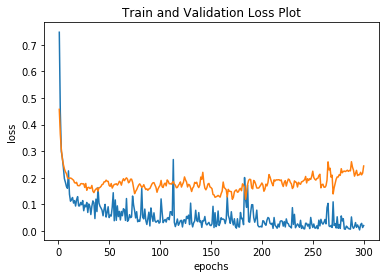

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(1,epochs+1), train_mean_losses)
plt.plot(range(1,epochs+1), valid_mean_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Loss Plot')
plt.show()

In [17]:
net.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [25]:
test_predictions = np.empty((0,3))
with torch.no_grad():
    for iteration, batch_data in enumerate(test_loader):
        X_batch, y_batch = batch_data        
        out = net(X_batch)
        
        test_predictions = np.append(test_predictions, out.numpy(), 
                                     axis=0)
        

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

test_predictions = np.array(test_predictions)
test_predictions = np.argmax(np.array(test_predictions), axis=1)

print("=========================================================\n")
print("Predicted Class:")
print(test_predictions)
print("\nGround Truth:")
print(test_y)

print("\n=========================================================\n")
print("Confusion Matrix:")
print(confusion_matrix(test_y, test_predictions))

print("\n=========================================================\n")
accuracy = accuracy_score(test_y, test_predictions)
print("Accuracy: {}".format(accuracy))

f1 = f1_score(test_y, test_predictions, average='macro')
print("F1 Score: ", f1)

print("\n=========================================================\n")
print("Classification Report:")
print(classification_report(test_y, test_predictions))



Predicted Class:
[1 2 2 1 2 1 0 1 0 2 2 1 0 1 2 0 2 1 2 2 0 0 1 2 0 2 1 0 1 0]

Ground Truth:
[1 2 2 2 2 2 0 1 0 2 2 1 0 1 2 0 2 1 2 2 0 0 1 2 0 2 1 0 1 0]


Confusion Matrix:
[[ 9  0  0]
 [ 0  8  0]
 [ 0  2 11]]


Accuracy: 0.9333333333333333
F1 Score:  0.9351851851851851


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.80      1.00      0.89         8
           2       1.00      0.85      0.92        13

    accuracy                           0.93        30
   macro avg       0.93      0.95      0.94        30
weighted avg       0.95      0.93      0.93        30

